In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('dataset_temperature_harian.csv', delimiter=';')
df.head()

,Tanggal,Tavg
0,01-07-2021,27.1
1,02-07-2021,27.6
2,03-07-2021,27.0
3,04-07-2021,26.5
4,05-07-2021,26.1


In [ ]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d-%m-%Y')
df = df.set_index('Tanggal')
df.head()

,Tavg
Tanggal,
2021-07-01,27.1
2021-07-02,27.6
2021-07-03,27.0
2021-07-04,26.5
2021-07-05,26.1


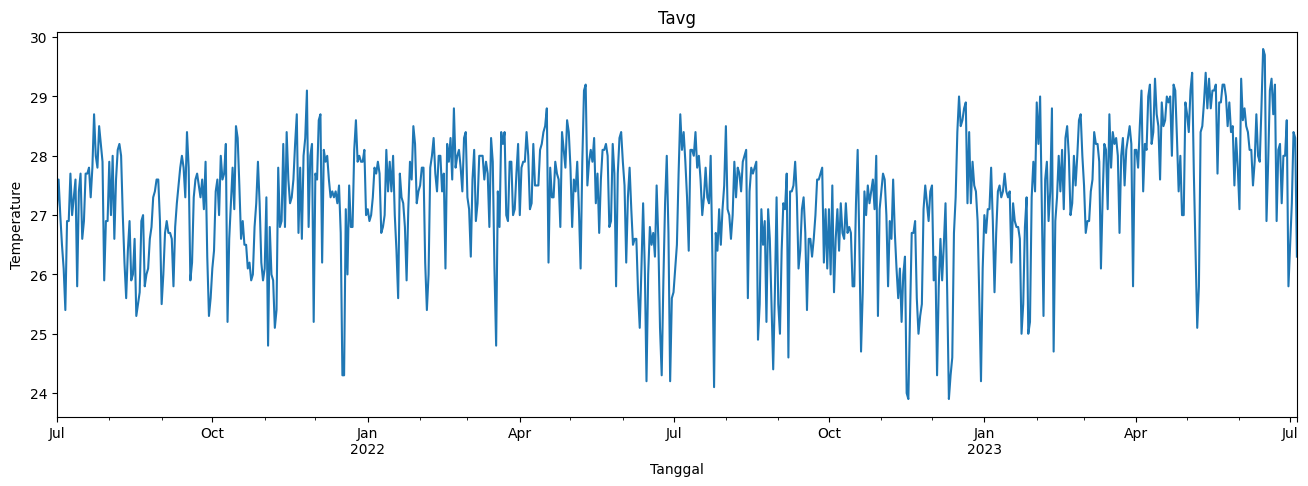

In [ ]:
# df.resample('MS').mean().index
ax = df['Tavg'].plot(figsize = (16,5), title = "Tavg")
ax.set(xlabel='Tanggal', ylabel='Temperature');

In [ ]:
data = df['Tavg'].values

In [ ]:
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=6.87 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2502.474, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2238.536, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.74 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2448.288, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2143.067, Time=0.72 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=12.14 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.52 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2199.541, Time=0.85 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2098.832, Time=1.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=2203.153, Time=0.53 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=21.08 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=11.53 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=2070.353, Time=2.23 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=216

In [ ]:
#splitting data

split_data = int(len(data) * 0.8)

train_data = data[:split_data]
test_data = data[split_data:]

print('Banyaknya data train :', len(train_data))
print('Banyaknya data test :', len(test_data))

Banyaknya data train : 588
Banyaknya data test : 147


In [ ]:
sarima_result = stepwise_model.fit(train_data)
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  588
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -803.317
Date:                            Thu, 27 Jul 2023   AIC                           1622.635
Time:                                    01:30:28   BIC                           1657.470
Sample:                                         0   HQIC                          1636.221
                                            - 588                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4241      0.039    -11.000      0.000      -0.500      -0.349
ar.L2         -0.3704      0.042   

In [ ]:
future_forecast = stepwise_model.predict(n_periods=len(test_data))

In [ ]:
print(len(future_forecast))
print(len(test_data))

147
147


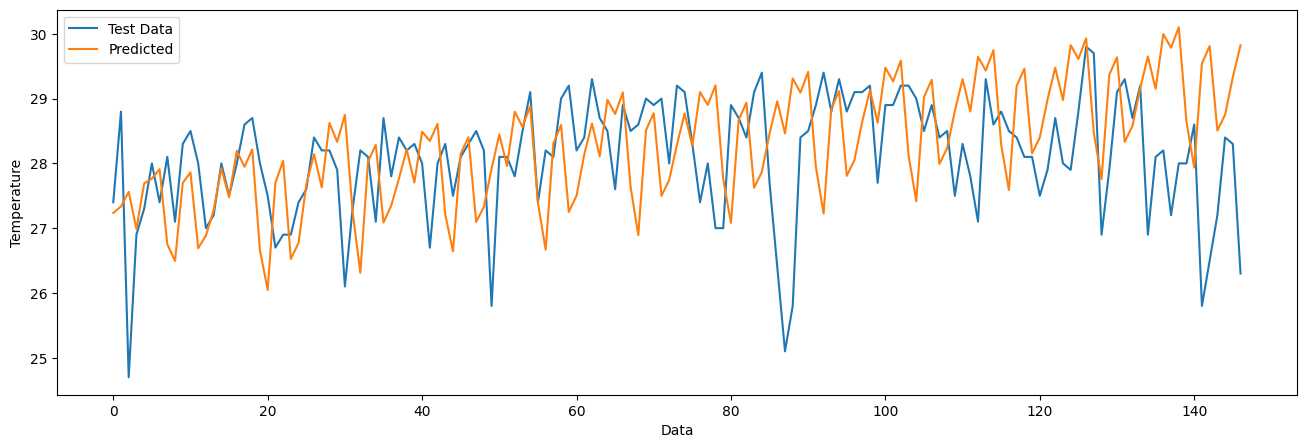

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))
plt.plot(test_data, label='Test Data')
plt.plot(future_forecast, label='Predicted')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Temperature');

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

evaluasi = mean_absolute_percentage_error(test_data, future_forecast)
print(evaluasi)

0.03364176459604737


In [ ]:
residual = test_data - future_forecast

In [ ]:
residual.shape

(147,)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

look_back = 2 #mengingat data dua hari sebelumnya
batch_test = 1 #mengelompokkan data sebanyak 1

test_generator = TimeseriesGenerator(residual, residual, length=look_back, batch_size=batch_test, shuffle=False)

In [ ]:
print(test_generator[0])

(array([[0.16586416, 1.46381684]]), array([-2.86101755]))


In [ ]:
import tensorflow as tf
from tensorflow.keras import Input
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM

#Menghapus sesi training
K.clear_session()

#Pembuatan model baseline
baseline_input_layer = Input(shape=(look_back, 1))
baseline_hidden_layer_1 = LSTM(50, activation='relu')(baseline_input_layer)
baseline_output_layer = Dense(1)(baseline_hidden_layer_1)

baseline_model = Model(inputs = baseline_input_layer, outputs = baseline_output_layer)
baseline_model.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
baseline_model.fit(test_generator,
          epochs=100, verbose=1)

Epoch 1/100
145/145 [==============================] - 2s 4ms/step - loss: 1.4579
Epoch 2/100
145/145 [==============================] - 1s 5ms/step - loss: 1.3636
Epoch 3/100
145/145 [==============================] - 0s 3ms/step - loss: 1.3302
Epoch 4/100
145/145 [==============================] - 0s 3ms/step - loss: 1.3021
Epoch 5/100
145/145 [==============================] - 0s 3ms/step - loss: 1.2741
Epoch 6/100
145/145 [==============================] - 0s 3ms/step - loss: 1.2616
Epoch 7/100
145/145 [==============================] - 0s 3ms/step - loss: 1.2558
Epoch 8/100
145/145 [==============================] - 0s 3ms/step - loss: 1.2432
Epoch 9/100
145/145 [==============================] - 0s 3ms/step - loss: 1.2451
Epoch 10/100
145/145 [==============================] - 0s 3ms/step - loss: 1.2371
Epoch 11/100
145/145 [==============================] - 0s 3ms/step - loss: 1.2316
Epoch 12/100
145/145 [==============================] - 0s 3ms/step - loss: 1.2316
Epoch 13/100


In [ ]:
prediksi_res_lstm = baseline_model.predict(test_generator)
prediksi_res_lstm = prediksi_res_lstm.reshape(-1)

145/145 [==============================] - 0s 2ms/step


In [ ]:
prediksi_res_lstm

array([ 5.19950502e-03, -1.57453370e+00,  8.48058537e-02, -8.61867964e-02,
        2.60450184e-01, -2.08878860e-01,  5.31339943e-01, -4.08078060e-02,
        6.96331114e-02,  6.37950897e-02, -8.25954080e-02, -1.30749375e-01,
        5.81572056e-02,  2.08568305e-01,  1.25459373e-01,  4.17718887e-02,
        3.92449319e-01,  8.36044848e-02, -5.23932055e-02, -3.05920631e-01,
       -9.64589715e-01, -7.87586093e-01,  2.99621671e-01,  9.52386633e-02,
       -5.44103086e-02,  2.89593607e-01,  1.16689309e-01, -2.93865263e-01,
       -2.16043860e-01, -1.40943336e+00,  1.43564120e-01, -1.47425942e-03,
       -3.59830499e-01, -4.39974666e-01,  6.61176920e-01, -2.96845715e-02,
        8.42269659e-02, -1.63128097e-02,  2.14018553e-01, -3.38484854e-01,
       -9.39153194e-01, -3.65066171e-01,  4.67708707e-01, -6.87085912e-02,
       -1.06625974e-01,  8.92560706e-02,  2.59320527e-01, -1.32060811e-01,
       -1.05564988e+00, -1.50655761e-01,  2.13101283e-01, -3.83680195e-01,
        1.01701971e-02,  

In [ ]:
vector1 = future_forecast
vector2 = prediksi_res_lstm
vector3 = residual

In [ ]:
# Determine the maximum size of the three vectors
max_size = max(vector1.size, vector2.size, vector3.size)

# Pad the vectors with zeros to make them of the same size as the maximum size
vector1_padded = np.pad(vector1, (0, max_size - vector1.size), mode='constant')
vector2_padded = np.pad(vector2, (0, max_size - vector2.size), mode='constant')
vector3_padded = np.pad(vector3, (0, max_size - vector3.size), mode='constant')

# Add the vectors element-wise
final_result = vector1_padded + vector2_padded + vector3_padded

In [ ]:
final_result

array([27.40519951, 27.2254663 , 24.78480585, 26.8138132 , 27.56045018,
       27.79112114, 27.93133994, 28.05919219, 27.16963311, 28.36379509,
       28.41740459, 27.86925063, 27.05815721, 27.4085683 , 28.12545937,
       27.54177189, 28.39244932, 28.68360448, 28.64760679, 27.69407937,
       26.53541028, 25.91241391, 27.19962167, 26.99523866, 27.34558969,
       27.88959361, 28.51668931, 27.90613474, 27.98395614, 26.49056664,
       26.24356412, 27.29852574, 27.8401695 , 27.66002533, 27.76117692,
       28.67031543, 27.88422697, 28.38368719, 28.41401855, 27.96151515,
       27.06084681, 26.33493383, 28.46770871, 28.23129141, 27.39337403,
       28.18925607, 28.55932053, 28.36793919, 27.14435012, 25.64934424,
       28.31310128, 27.71631981, 27.8101702 , 28.77727586, 29.18823122,
       27.4825679 , 27.76141368, 28.43137009, 28.85384507, 29.03416572,
       28.31151458, 28.499696  , 29.35942208, 28.3662994 , 27.78054029,
       27.5143006 , 29.31796491, 28.26218075, 28.54744955, 29.09

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

evaluasi = mean_absolute_percentage_error(test_data, final_result)
print(evaluasi)

0.015114341202369526


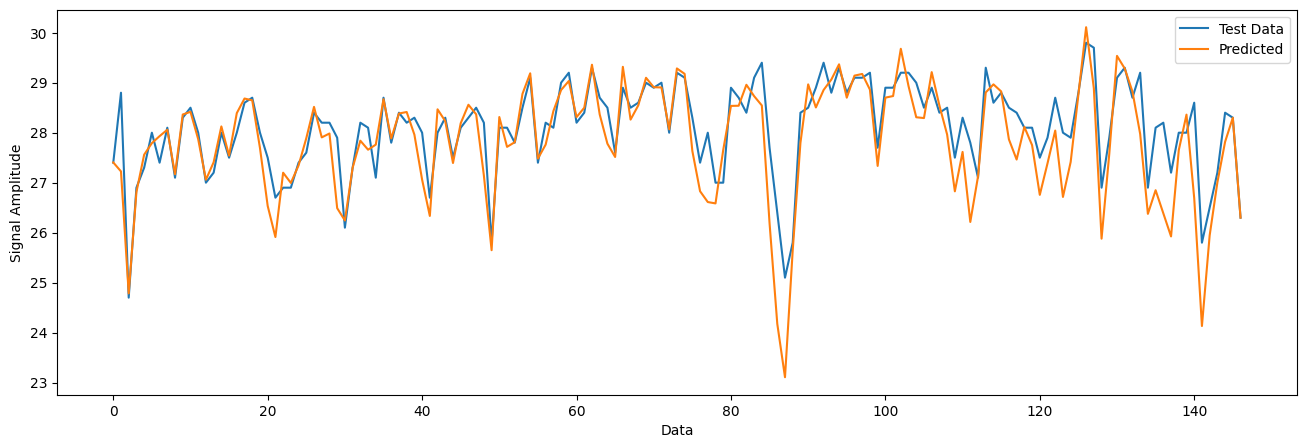

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))
plt.plot(test_data, label='Test Data')
plt.plot(final_result, label='Predicted')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Signal Amplitude');